## Bernstein-Vazirani's Algorithm

This algorithm is one of the ones that are way more efficient on a quantum computer than on a classical computer.  
It works as follows:
- there's a secret number the algorithm has to guess
- it finds it in one shot, no matter the size of the number

On a classical computer, given an n-bit number (e.g. 1011 has n=4), the algorithm is as follows:
- for n times, check with a bitwise AND operation if the nth bit is a 1

The secret number is 0000


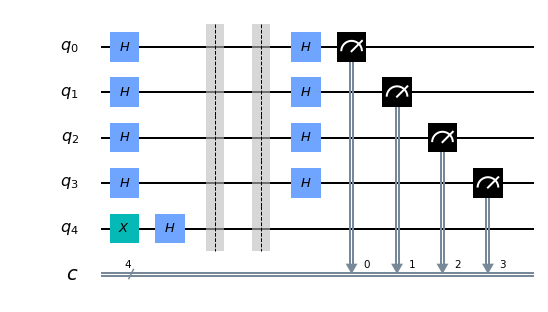

In [1]:
%matplotlib inline

import qiskit as q
from qiskit.tools.visualization import plot_histogram
from random import choice

number_length = 4  # max 4 (there are 5 qubits in a real quantum computer)
bits = ['0', '1']

def make_circuit_for_number(number_length: int) -> q.QuantumCircuit:
    # choose secret number
    secret_number = ""
    for bit in range(number_length):
        secret_number += choice(bits)
    print(f"The secret number is {secret_number}")

    # make quantum circuit
    qc = q.QuantumCircuit(number_length+1, number_length)  # qbits, cbits
    qc.h(range(number_length))
    qc.x(number_length)
    qc.h(number_length)
    qc.barrier()

    for i, is_one in enumerate(reversed([(bit == '1') for bit in secret_number])):
        if is_one:
            qc.cx(i, number_length)

    qc.barrier()
    qc.h(range(number_length))
    qc.measure(range(number_length), range(number_length))
    
    return qc

qc = make_circuit_for_number(number_length)
qc.draw(output='mpl')

In [2]:
q.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# run on real quantum computer

from qiskit.tools.monitor import job_monitor

provider = q.IBMQ.get_provider("ibm-q")
queued = float("inf")

for backend in [backend for backend in provider.backends() if backend.properties()]: # discard simulator
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {len(backend.properties().qubits)} qubits")
    if backend.status().pending_jobs < queued:
        queued = backend.status().pending_jobs
        backend_to_use = backend
        
print(f"\nThe chosen backend is {backend_to_use.name()}, with a queue of {backend_to_use.status().pending_jobs} jobs.")

backend = provider.get_backend(backend_to_use.name())
# only one shot is required for this algorithm, instead of the 2*n loops required for a classical computer
# running 10 times since noise could deviate the result
job = q.execute(qc, backend=backend, shots=10)  
job_monitor(job)

ibmqx2 has 1 queued and 5 qubits
ibmq_16_melbourne has 13 queued and 14 qubits
ibmq_vigo has 0 queued and 5 qubits
ibmq_ourense has 38 queued and 5 qubits
ibmq_london has 12 queued and 5 qubits
ibmq_burlington has 0 queued and 5 qubits
ibmq_essex has 0 queued and 5 qubits

The chosen backend is ibmq_vigo, with a queue of 0 jobs.
Job Status: job has successfully run


In [4]:
# run on simulator (max 32 qubits)

qc = make_circuit_for_number(number_length=100)
# qc.draw(output='mpl')  # only draws first circuit

sim = q.Aer.get_backend("qasm_simulator")
job_sim = q.execute(qc, backend=sim, shots=1)

The secret number is 1001011101000011001110101111011011100101000101011011010010101100011000010010110101100010000100011110


In [5]:
# print results

print("Real Quantum Computer:")
print(f"The secret number was {job.result().get_counts()}")

print("\nSimulator:")
print(f"The secret number was {job_sim.result().get_counts()}")

Real Quantum Computer:
The secret number was {'0000': 6, '0010': 1, '0001': 3}

Simulator:
The secret number was {'1001011101000011001110101111011011100101000101011011010010101100011000010010110101100010000100011110': 1}
